In [0]:
'''
Changes compared to try7_day:
* instead of 24hour average bot takes 1 hour
* game initialization now can start with either BTC or EUR, while, in original try 7 it was only BTC
* crash of game removed
'''

'\nChanges compared to try7_day:\n* instead of 24hour average bot takes 8 hours\n* game initialization now can start with either BTC or EUR, while, in original try 7 it was only BTC\n* crash of game removed\n'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/YouTube/BTC_bot/deepQ/')
os.getcwd()

'/content/drive/My Drive/YouTube/BTC_bot/deepQ'

In [3]:
'''
Trading training module for BTC bot. Deep Q learning version
'''

# check line 31 to load/start new modelling

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
import keras
import random
import numpy as np
import pandas as pd
from operator import add


class TraderMan(object):
    init_BTC_wallet = 1  # BTC wallet in BTC
    init_EUR_wallet = 0  # EUR wallet in BTC
    
    init_trade_tax = 0.005  # tax ratio =0.5percent
    
    def __init__(self, BTC=init_BTC_wallet, EUR=init_EUR_wallet, trade_tax=init_trade_tax):
        self.reward = 0
        self.gamma = 0.9
        self.dataframe = pd.DataFrame()
        self.short_memory = np.array([])
        self.agent_target = 1
        self.agent_predict = 0
        self.learning_rate = 0.0005
        # self.model = self.network()
        self.model = self.network("bitMcCoin_1-hour.hdf5")
        self.epsilon = 0
        self.actual = []
        self.memory = []
        
        self.BTC = BTC
        self.EUR = EUR
        self.trade_tax = trade_tax
        
        self.close_price = 1  # sets a variable to remember last closing price
        self.nextClosePrice = 1  # sets a variable for the upcoming price to evaluate current decision, at try5 made to be an average of a time period
        
        self.steps_done = 0 # calcs different steps taken
        self.BUY = 0
        self.SELL = 0 
        
        self.old_position = [1, 0]
        
    def last_action(self):
        '''
        Returns last action as sell or buy in binary (0,1).
        '''
        if self.EUR==0:
            return 1  # BUY
        else:
            return 0  # SELL
        
    def get_state(self, df, line_no):
        '''
        Gets input values
        '''
        state = df.drop(columns='Close').iloc[line_no].to_list()
        trade_pos = self.last_action()  # current state of the wallet
        state.append(trade_pos)

        return np.asarray(state)
    
    def get_reward(self, in_coins=True, next_interval=False, raw=False, old_position=False):
        '''
        Returns wallet information. BTC and EUR
        
        in_coins - return wallet amount in BTC or EUR. Default BTC.
        next_interval - return wallet for next close price
        raw - return wallet in BTC, EUR or just one. see in_coins
        old_position - should the price be retuned on position before the trade or after
        '''
        # determines the price and wallet needed
        if next_interval==False:
          priceUsed = self.close_price
        else:
          priceUsed = self.nextClosePrice
          
        if old_position == False:  # checks for what to calc the prices, old position or new
          used_BTC = self.BTC
          used_EUR = self.EUR
        else:
          used_BTC = self.old_position[0]
          used_EUR = self.old_position[1]
        
        # returns wallet info
        if raw == True:
          return used_BTC, used_EUR
        else:
          if in_coins == True:
              return used_BTC, (used_EUR*(1/priceUsed))
          else:
              return (used_BTC*priceUsed), used_EUR

    def set_reward(self, trader, crash, action):
        ''' 
        Returns positive rewards for increasement of total portfolio, 
        evaluated based on the next interval price.
        '''
        self.reward = 0
        
        # sets the score even if the action can't be processed due to lack of EUR/BTC in wallets
        if np.array_equal(action, [1, 0, 0]):  # BUY
          old_score = self.close_price
          new_score = self.nextClosePrice
        elif np.array_equal(action, [0, 0, 1]):  # SELL
          new_score = self.close_price
          old_score = self.nextClosePrice
        else: 
          new_score = 1
          old_score = 1
        
        delta_score = (new_score * (1-self.trade_tax) - old_score)/old_score*100
    
        if delta_score != 0:
            self.reward = delta_score

        return self.reward
        
    def step(self, close_price, action):
        '''
        close - closing price
        action - tanh output from nnet
        '''
        self.steps_done += 1
        
        a = action
        
        # readability
        EUR = self.EUR
        BTC = self.BTC
        trade_tax = self.trade_tax
        
        # update old price
        self.close_price = close_price
        
        if np.array_equal(a, [1, 0, 0]):  # BUY
            new_wallet = EUR*(1/close_price)
            new_wallet -= trade_tax*new_wallet
            self.BTC = new_wallet
            self.EUR = 0
            self.BUY += 1
        elif np.array_equal(a, [0, 0, 1]):  # SELL
            new_wallet = BTC*close_price
            new_wallet -= trade_tax*new_wallet
            self.EUR = new_wallet
            self.BTC = 0
            self.SELL += 1
        
    def network(self, saved_model=None):
        '''
        Builds the network.
        '''
        if saved_model:
            model = keras.models.load_model(saved_model)
        else:
          model = Sequential()
          model.add(Dense(output_dim=120, activation='relu', input_dim=16))
          model.add(Dropout(0.15))
          model.add(Dense(output_dim=120, activation='relu'))
          model.add(Dropout(0.15))
          model.add(Dense(output_dim=120, activation='relu'))
          model.add(Dropout(0.15))
          model.add(Dense(output_dim=3, activation='softmax'))
          opt = Adam(self.learning_rate)
          model.compile(loss='mse', optimizer=opt)
        
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def replay_new(self, memory):
        self.BTC = 1
        self.EUR = 0
        
        self.close_price = 1  # sets a variable to remember last closing price
        self.steps_done = 0
        self.BUY = 0
        self.SELL = 0
        
        if len(memory) > 1000:
            minibatch = random.sample(memory, 1000)
        else:
            minibatch = memory
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(np.array([next_state]))[0])
            target_f = self.model.predict(np.array([state]))
            target_f[0][np.argmax(action)] = target
            self.model.fit(np.array([state]), target_f, epochs=1, verbose=0)

    def train_short_memory(self, state, action, reward, next_state, done):
        target = reward
        if not done:
            target = reward + self.gamma * np.amax(self.model.predict(next_state.reshape((1, 16)))[0])
        target_f = self.model.predict(state.reshape((1, 16)))
        target_f[0][np.argmax(action)] = target
        self.model.fit(state.reshape((1, 16)), target_f, epochs=1, verbose=0)
    

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.









Started with EUR
--------------------------------------
Game 1 

Selected lines:  788540 789979
Prices:          6750.81 6686.26 

       EUR: 1706.29 
       BTC: 0.26 
       Steps done:  1439 1.00 
       BUYs done:   138 
       SELLs done:  139 
       Total done:  0.19 
       Random done:  613 



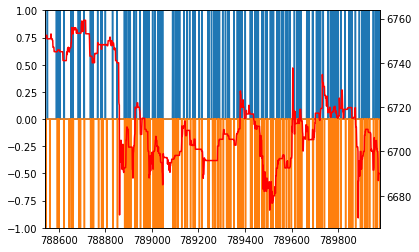

-------------------------------------- 

Started with BTC
--------------------------------------
Game 2 

Selected lines:  297781 299220
Prices:          2855.59 2732.59 

       EUR: 649.59 
       BTC: 0.24 
       Steps done:  1439 1.00 
       BUYs done:   148 
       SELLs done:  149 
       Total done:  0.21 
       Random done:  536 



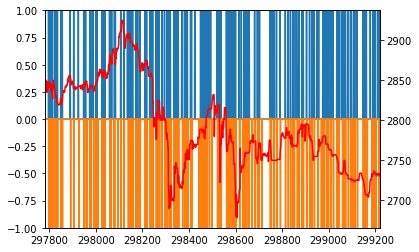

-------------------------------------- 

Started with BTC
--------------------------------------
Game 3 

Selected lines:  225570 227009
Prices:          2948.98 2816.76 

       EUR: 818.78 
       BTC: 0.29 
       Steps done:  1439 1.00 
       BUYs done:   129 
       SELLs done:  130 
       Total done:  0.18 
       Random done:  470 



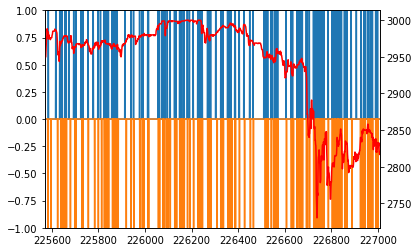

-------------------------------------- 

Started with BTC
--------------------------------------
Game 4 

Selected lines:  435951 437390
Prices:          7450.0 7273.09 

       EUR: 2288.47 
       BTC: 0.31 
       Steps done:  1439 1.00 
       BUYs done:   120 
       SELLs done:  120 
       Total done:  0.17 
       Random done:  413 



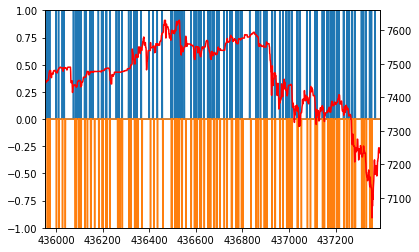

-------------------------------------- 

Started with EUR
--------------------------------------
Game 5 

Selected lines:  511061 512500
Prices:          15835.0 14109.98 

       EUR: 6979.27 
       BTC: 0.49 
       Steps done:  1439 1.00 
       BUYs done:   90 
       SELLs done:  91 
       Total done:  0.13 
       Random done:  340 



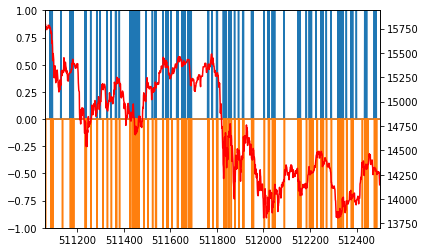

-------------------------------------- 

Started with BTC
--------------------------------------
Game 6 

Selected lines:  1014079 1015518
Prices:          3393.21 3274.41 

       EUR: 1561.57 
       BTC: 0.48 
       Steps done:  1439 1.00 
       BUYs done:   78 
       SELLs done:  79 
       Total done:  0.11 
       Random done:  265 



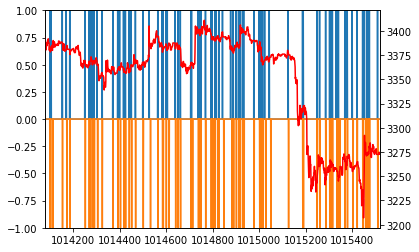

-------------------------------------- 

Started with BTC
--------------------------------------
Game 7 

Selected lines:  689947 691386
Prices:          9207.0 9065.39 

       EUR: 3862.55 
       BTC: 0.43 
       Steps done:  1439 1.00 
       BUYs done:   88 
       SELLs done:  89 
       Total done:  0.12 
       Random done:  228 



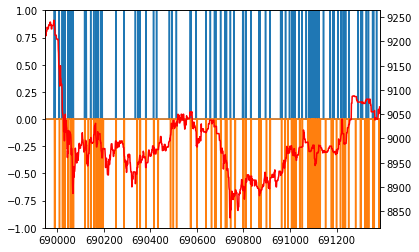

-------------------------------------- 

Started with EUR
--------------------------------------
Game 8 

Selected lines:  684909 686348
Prices:          9315.28 9226.06 

       EUR: 3892.08 
       BTC: 0.42 
       Steps done:  1439 1.00 
       BUYs done:   92 
       SELLs done:  92 
       Total done:  0.13 
       Random done:  0 



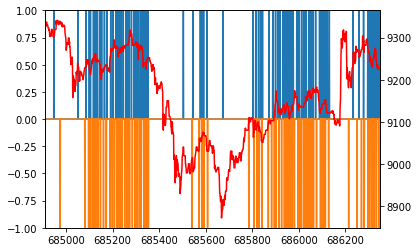

-------------------------------------- 

Started with EUR
--------------------------------------
Game 9 

Selected lines:  410598 412037
Prices:          5286.0 5672.92 

       EUR: 3177.31 
       BTC: 0.56 
       Steps done:  1439 1.00 
       BUYs done:   62 
       SELLs done:  62 
       Total done:  0.09 
       Random done:  0 



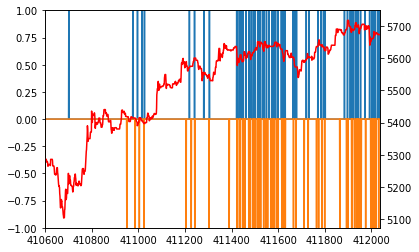

-------------------------------------- 

Started with BTC
--------------------------------------
Game 10 

Selected lines:  850516 851955
Prices:          6428.87 6676.75 

       EUR: 1879.25 
       BTC: 0.28 
       Steps done:  1439 1.00 
       BUYs done:   129 
       SELLs done:  130 
       Total done:  0.18 
       Random done:  0 



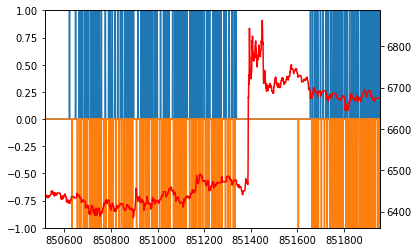

-------------------------------------- 



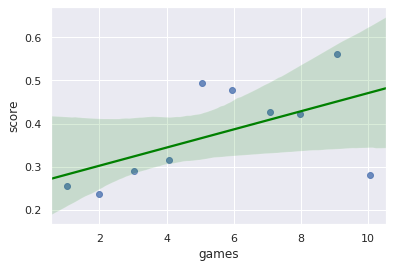

Started with BTC
--------------------------------------
Game 11 

Selected lines:  97876 99315
Prices:          1236.9 1249.41 

       EUR: 299.66 
       BTC: 0.24 
       Steps done:  1439 1.00 
       BUYs done:   141 
       SELLs done:  142 
       Total done:  0.20 
       Random done:  610 



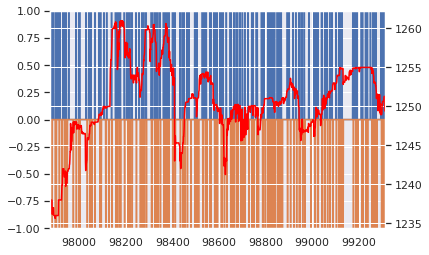

-------------------------------------- 

Started with BTC
--------------------------------------
Game 12 

Selected lines:  192699 194138
Prices:          1930.04 2029.82 

       EUR: 557.55 
       BTC: 0.27 
       Steps done:  1439 1.00 
       BUYs done:   126 
       SELLs done:  127 
       Total done:  0.18 
       Random done:  513 



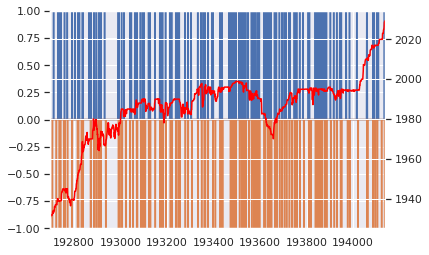

-------------------------------------- 

Started with BTC
--------------------------------------
Game 13 

Selected lines:  54998 56437
Prices:          983.2 1013.75 

       EUR: 324.04 
       BTC: 0.32 
       Steps done:  1439 1.00 
       BUYs done:   113 
       SELLs done:  114 
       Total done:  0.16 
       Random done:  480 



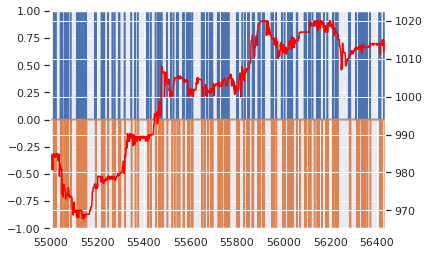

-------------------------------------- 

Started with EUR
--------------------------------------
Game 14 

Selected lines:  664758 666197
Prices:          8100.0 8007.0 

       EUR: 2694.25 
       BTC: 0.34 
       Steps done:  1439 1.00 
       BUYs done:   110 
       SELLs done:  111 
       Total done:  0.15 
       Random done:  383 



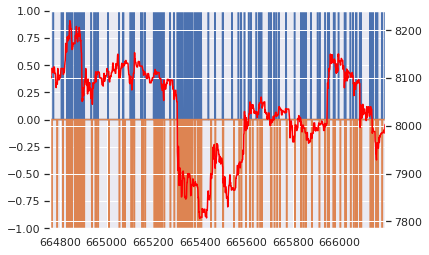

-------------------------------------- 

Started with BTC
--------------------------------------
Game 15 

Selected lines:  207225 208664
Prices:          2336.21 2213.9 

       EUR: 887.49 
       BTC: 0.40 
       Steps done:  1439 1.00 
       BUYs done:   98 
       SELLs done:  99 
       Total done:  0.14 
       Random done:  344 



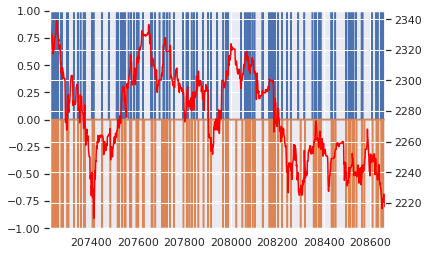

-------------------------------------- 

Started with BTC
--------------------------------------
Game 16 

Selected lines:  691162 692601
Prices:          8973.13 9079.86 

       EUR: 2596.67 
       BTC: 0.29 
       Steps done:  1439 1.00 
       BUYs done:   126 
       SELLs done:  127 
       Total done:  0.18 
       Random done:  270 



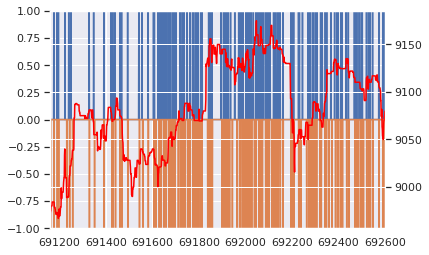

-------------------------------------- 

Started with BTC
--------------------------------------
Game 17 

Selected lines:  19485 20924
Prices:          815.5 831.65 

       EUR: 406.51 
       BTC: 0.49 
       Steps done:  1439 1.00 
       BUYs done:   79 
       SELLs done:  80 
       Total done:  0.11 
       Random done:  207 



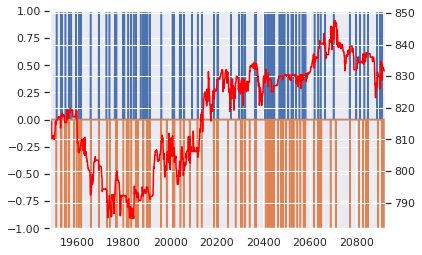

-------------------------------------- 

Started with EUR
--------------------------------------
Game 18 

Selected lines:  321339 322778
Prices:          4360.0 4279.99 

       EUR: 2940.14 
       BTC: 0.69 
       Steps done:  1439 1.00 
       BUYs done:   47 
       SELLs done:  48 
       Total done:  0.07 
       Random done:  0 



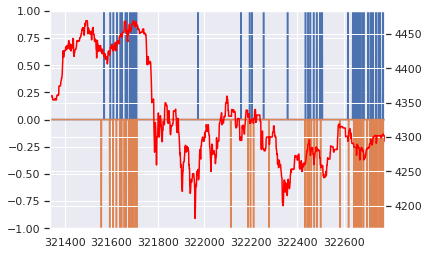

-------------------------------------- 

Started with BTC
--------------------------------------
Game 19 

Selected lines:  713413 714852
Prices:          8273.22 8122.0 

       EUR: 3017.16 
       BTC: 0.37 
       Steps done:  1439 1.00 
       BUYs done:   104 
       SELLs done:  104 
       Total done:  0.14 
       Random done:  0 



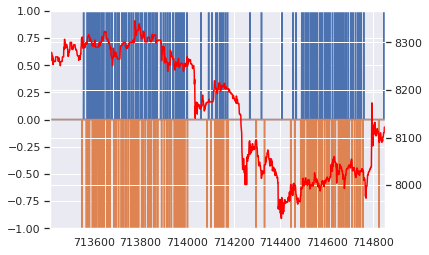

-------------------------------------- 

Started with EUR
--------------------------------------
Game 20 

Selected lines:  448036 449475
Prices:          6624.93 6597.86 

       EUR: 5420.82 
       BTC: 0.82 
       Steps done:  1439 1.00 
       BUYs done:   30 
       SELLs done:  31 
       Total done:  0.04 
       Random done:  0 



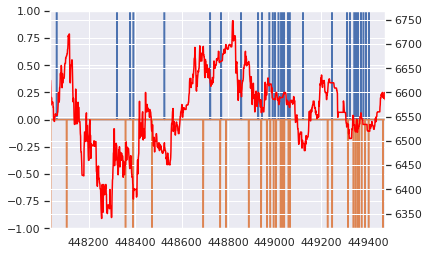

-------------------------------------- 



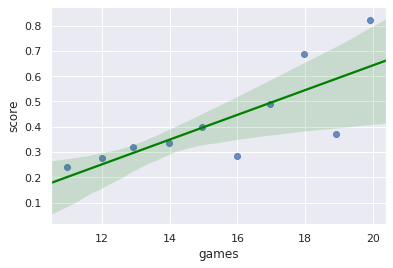

Started with BTC
--------------------------------------
Game 21 

Selected lines:  131513 132952
Prices:          1194.67 1188.9 

       EUR: 241.99 
       BTC: 0.20 
       Steps done:  1439 1.00 
       BUYs done:   159 
       SELLs done:  160 
       Total done:  0.22 
       Random done:  626 



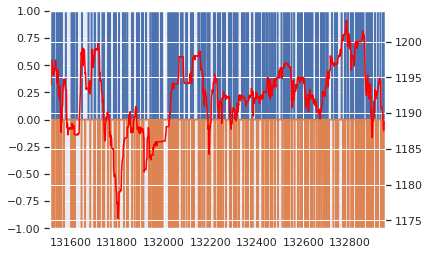

-------------------------------------- 

Started with BTC
--------------------------------------
Game 22 

Selected lines:  226502 227941
Prices:          2960.2 2748.9 

       EUR: 764.76 
       BTC: 0.28 
       Steps done:  1439 1.00 
       BUYs done:   136 
       SELLs done:  136 
       Total done:  0.19 
       Random done:  544 



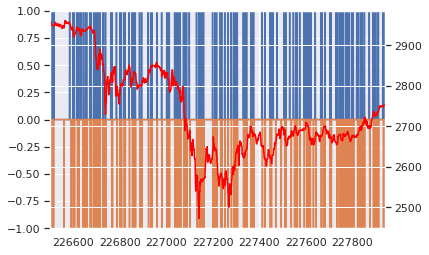

-------------------------------------- 

Started with EUR
--------------------------------------
Game 23 

Selected lines:  420775 422214
Prices:          5470.0 5925.03 

       EUR: 1855.54 
       BTC: 0.31 
       Steps done:  1439 1.00 
       BUYs done:   114 
       SELLs done:  114 
       Total done:  0.16 
       Random done:  435 



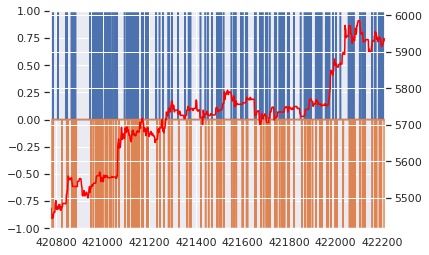

-------------------------------------- 

Started with BTC
--------------------------------------
Game 24 

Selected lines:  604003 605442
Prices:          11065.1 11353.9 

       EUR: 3146.95 
       BTC: 0.28 
       Steps done:  1439 1.00 
       BUYs done:   129 
       SELLs done:  130 
       Total done:  0.18 
       Random done:  400 



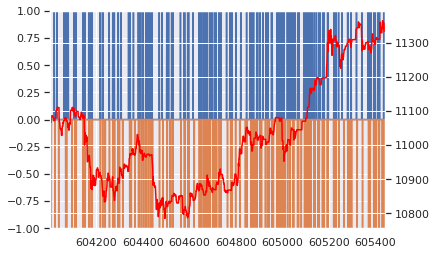

-------------------------------------- 

Started with BTC
--------------------------------------
Game 25 

Selected lines:  152067 153506
Prices:          1257.68 1243.34 

       EUR: 365.13 
       BTC: 0.29 
       Steps done:  1439 1.00 
       BUYs done:   124 
       SELLs done:  125 
       Total done:  0.17 
       Random done:  316 



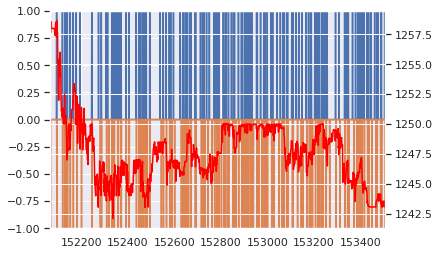

-------------------------------------- 

Started with EUR
--------------------------------------
Game 26 

Selected lines:  626664 628103
Prices:          7808.01 8340.01 

       EUR: 4231.37 
       BTC: 0.51 
       Steps done:  1439 1.00 
       BUYs done:   74 
       SELLs done:  74 
       Total done:  0.10 
       Random done:  271 



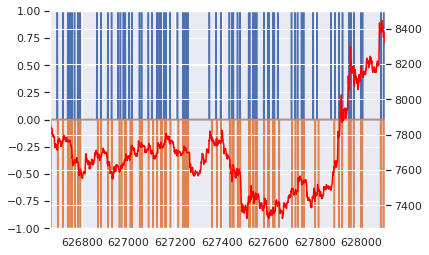

-------------------------------------- 

Started with BTC
--------------------------------------
Game 27 

Selected lines:  493777 495216
Prices:          17600.01 18555.0 

       EUR: 6356.23 
       BTC: 0.34 
       Steps done:  1439 1.00 
       BUYs done:   108 
       SELLs done:  108 
       Total done:  0.15 
       Random done:  213 



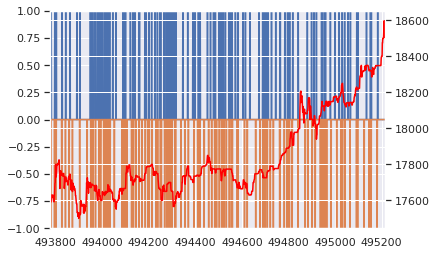

-------------------------------------- 

Started with BTC
--------------------------------------
Game 28 

Selected lines:  900583 902022
Prices:          6467.77 6395.0 

       EUR: 1194.39 
       BTC: 0.19 
       Steps done:  1439 1.00 
       BUYs done:   170 
       SELLs done:  170 
       Total done:  0.24 
       Random done:  0 



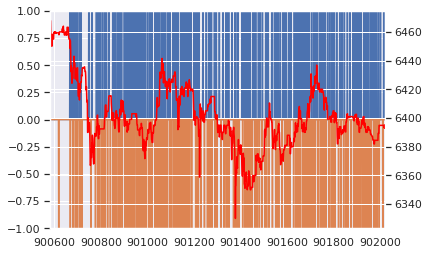

-------------------------------------- 

Started with BTC
--------------------------------------
Game 29 

Selected lines:  194912 196351
Prices:          2069.86 2172.32 

       EUR: 1475.07 
       BTC: 0.68 
       Steps done:  1439 1.00 
       BUYs done:   45 
       SELLs done:  46 
       Total done:  0.06 
       Random done:  0 



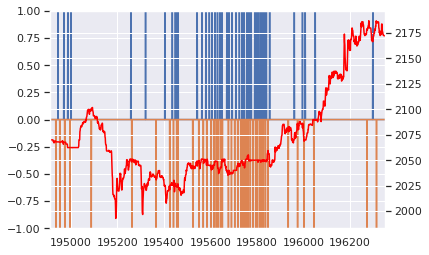

-------------------------------------- 

Started with EUR
--------------------------------------
Game 30 

Selected lines:  511249 512688
Prices:          14800.08 14109.95 

       EUR: 15579.32 
       BTC: 1.10 
       Steps done:  1439 1.00 
       BUYs done:   5 
       SELLs done:  6 
       Total done:  0.01 
       Random done:  0 



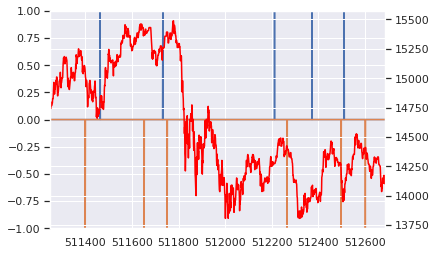

-------------------------------------- 



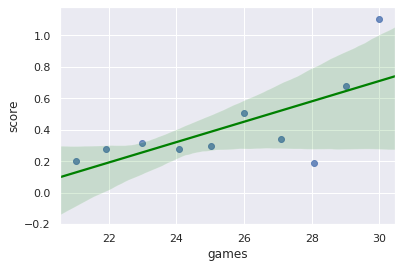

Started with BTC
--------------------------------------
Game 31 

Selected lines:  23665 25104
Prices:          860.0 902.83 

       EUR: 210.38 
       BTC: 0.23 
       Steps done:  1439 1.00 
       BUYs done:   144 
       SELLs done:  145 
       Total done:  0.20 
       Random done:  635 



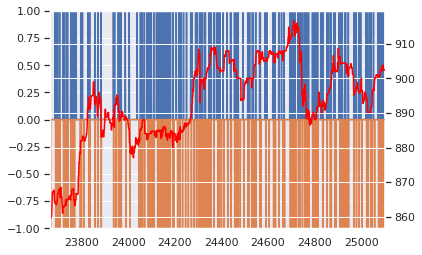

-------------------------------------- 

Started with BTC
--------------------------------------
Game 32 

Selected lines:  991809 993248
Prices:          3718.16 4182.19 

       EUR: 1051.98 
       BTC: 0.25 
       Steps done:  1439 1.00 
       BUYs done:   137 
       SELLs done:  138 
       Total done:  0.19 
       Random done:  545 



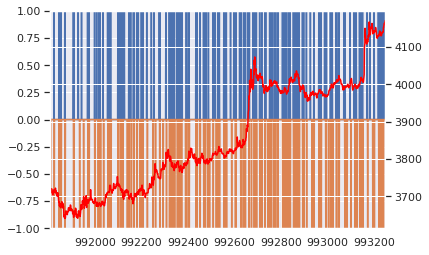

-------------------------------------- 

Started with BTC
--------------------------------------
Game 33 

Selected lines:  584822 586261
Prices:          10186.99 10969.0 

       EUR: 3205.76 
       BTC: 0.29 
       Steps done:  1439 1.00 
       BUYs done:   118 
       SELLs done:  118 
       Total done:  0.16 
       Random done:  483 



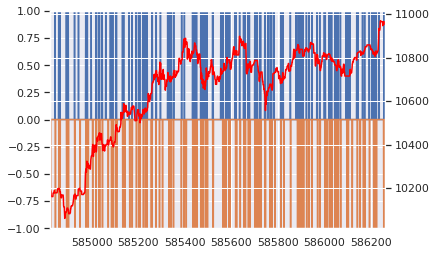

-------------------------------------- 

Started with EUR
--------------------------------------
Game 34 

Selected lines:  230713 232152
Prices:          2376.0 2426.9 

       EUR: 1017.69 
       BTC: 0.42 
       Steps done:  1439 1.00 
       BUYs done:   104 
       SELLs done:  105 
       Total done:  0.15 
       Random done:  409 



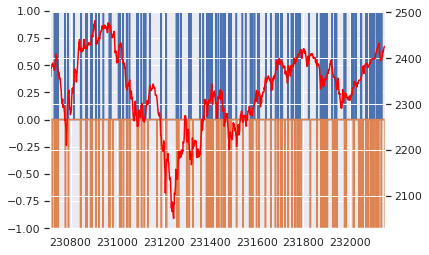

-------------------------------------- 

Started with BTC
--------------------------------------
Game 35 

Selected lines:  74162 75601
Prices:          1183.97 1155.24 

       EUR: 413.69 
       BTC: 0.36 
       Steps done:  1439 1.00 
       BUYs done:   105 
       SELLs done:  106 
       Total done:  0.15 
       Random done:  331 



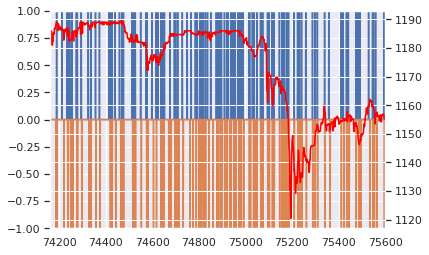

-------------------------------------- 

Started with EUR
--------------------------------------
Game 36 

Selected lines:  861802 863241
Prices:          7065.5 6978.99 

       EUR: 2167.95 
       BTC: 0.31 
       Steps done:  1439 1.00 
       BUYs done:   117 
       SELLs done:  118 
       Total done:  0.16 
       Random done:  294 



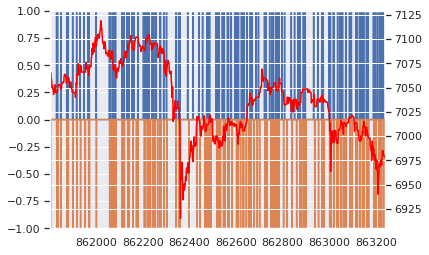

-------------------------------------- 

Started with EUR
--------------------------------------
Game 37 

Selected lines:  36329 37768
Prices:          920.67 923.21 

       EUR: 192.63 
       BTC: 0.21 
       Steps done:  1439 1.00 
       BUYs done:   156 
       SELLs done:  156 
       Total done:  0.22 
       Random done:  194 



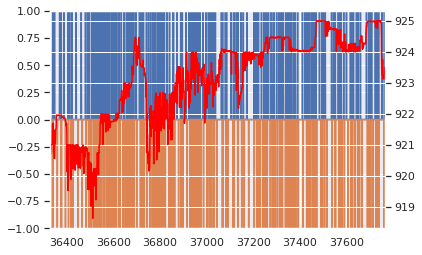

-------------------------------------- 

Started with EUR
--------------------------------------
Game 38 

Selected lines:  661744 663183
Prices:          6855.0 6836.0 

       EUR: 1625.48 
       BTC: 0.24 
       Steps done:  1439 1.00 
       BUYs done:   146 
       SELLs done:  147 
       Total done:  0.20 
       Random done:  0 



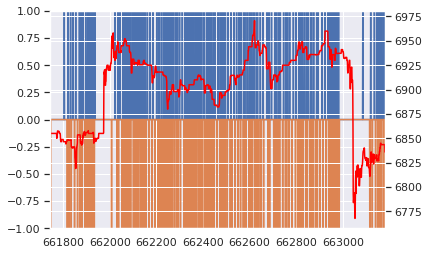

-------------------------------------- 

Started with BTC
--------------------------------------
Game 39 

Selected lines:  192599 194038
Prices:          1935.56 2000.0 

       EUR: 473.65 
       BTC: 0.24 
       Steps done:  1439 1.00 
       BUYs done:   145 
       SELLs done:  145 
       Total done:  0.20 
       Random done:  0 



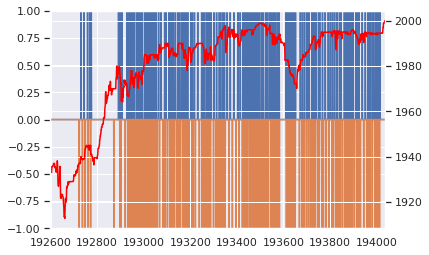

-------------------------------------- 

Started with BTC
--------------------------------------
Game 40 

Selected lines:  791643 793082
Prices:          6396.44 6370.08 

       EUR: 1488.69 
       BTC: 0.23 
       Steps done:  1439 1.00 
       BUYs done:   149 
       SELLs done:  150 
       Total done:  0.21 
       Random done:  0 



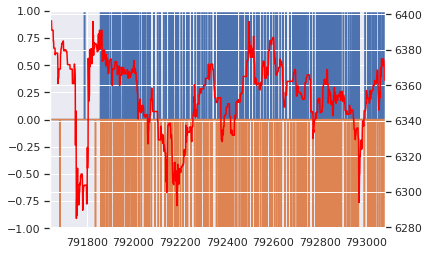

-------------------------------------- 



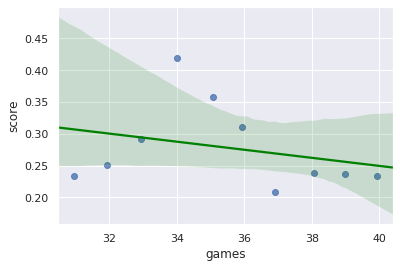

Started with BTC
--------------------------------------
Game 41 

Selected lines:  737138 738577
Prices:          7631.38 7690.0 

       EUR: 1681.50 
       BTC: 0.22 
       Steps done:  1439 1.00 
       BUYs done:   151 
       SELLs done:  152 
       Total done:  0.21 
       Random done:  615 



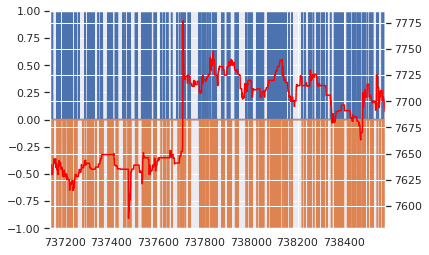

-------------------------------------- 

Started with BTC
--------------------------------------
Game 42 

Selected lines:  216451 217890
Prices:          2587.0 2844.09 

       EUR: 781.48 
       BTC: 0.27 
       Steps done:  1439 1.00 
       BUYs done:   123 
       SELLs done:  124 
       Total done:  0.17 
       Random done:  546 



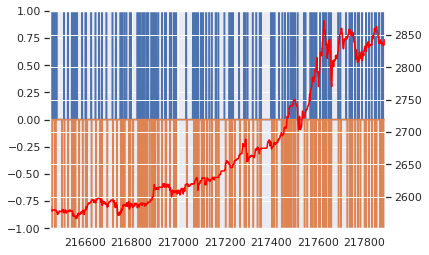

-------------------------------------- 

Started with BTC
--------------------------------------
Game 43 

Selected lines:  515887 517326
Prices:          13235.03 13995.0 

       EUR: 4594.26 
       BTC: 0.33 
       Steps done:  1439 1.00 
       BUYs done:   109 
       SELLs done:  110 
       Total done:  0.15 
       Random done:  466 



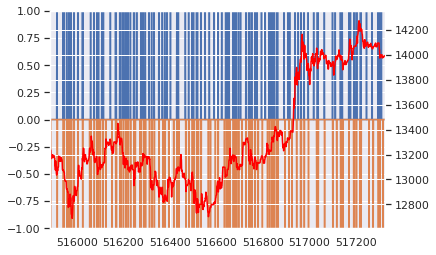

-------------------------------------- 

Started with BTC
--------------------------------------
Game 44 

Selected lines:  39471 40910
Prices:          920.11 923.36 

       EUR: 268.74 
       BTC: 0.29 
       Steps done:  1439 1.00 
       BUYs done:   123 
       SELLs done:  123 
       Total done:  0.17 
       Random done:  410 



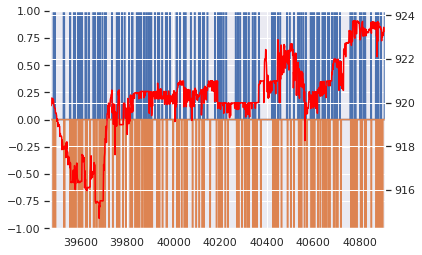

-------------------------------------- 

Started with BTC
--------------------------------------
Game 45 

Selected lines:  467644 469083
Prices:          9680.0 9849.99 

       EUR: 3454.22 
       BTC: 0.35 
       Steps done:  1439 1.00 
       BUYs done:   107 
       SELLs done:  107 
       Total done:  0.15 
       Random done:  323 



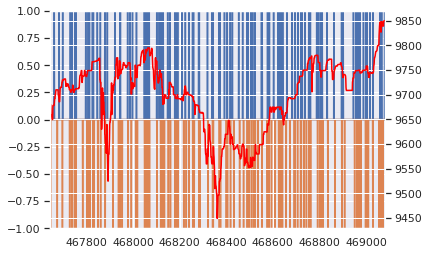

-------------------------------------- 

Started with EUR
--------------------------------------
Game 46 

Selected lines:  740565 742004
Prices:          7436.04 7610.44 

       EUR: 1911.18 
       BTC: 0.25 
       Steps done:  1439 1.00 
       BUYs done:   140 
       SELLs done:  141 
       Total done:  0.20 
       Random done:  269 



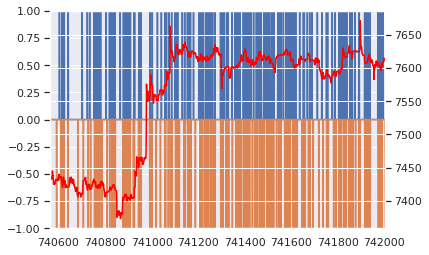

-------------------------------------- 

Started with EUR
--------------------------------------
Game 47 

Selected lines:  993165 994604
Prices:          4116.04 4247.01 



In [0]:
from random import randint
# from TraderMan import TraderMan
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random

# based on
# https://towardsdatascience.com/how-to-teach-an-ai-to-play-games-deep-reinforcement-learning-28f9b920440a
# https://github.com/maurock/snake-ga

# data load and setting
trainDf = pd.read_csv('./data/trainBTC2.csv')
trainLen = len(trainDf)
trainIntensity = 1440  # how many time intervals to take for samples in minutes, 10080=1 week, 1440=1day

reward_period = (1*60)  # at which point should the nextClosePrice be taken to measure the succesess of an action, takes average of the named amount, i.e. 1440 average price for the whole day after the trade.

lastPossibleLine = trainLen-reward_period-trainIntensity-1

games_to_play = 100

class Game:
    
    def __init__(self):
        self.score = 0
        self.crash = False
        self.steps = 0
        self.trader = Trader(self)
        
class Trader:
    
    def __init__(self, game):
        self.steps = 0
        self.trade_pos = 1
        self.last_score = 0
        
    def do_move(self, action, game, agent, closePrice, nextClosePrice):
        '''
        Checks if move is valid and if so sends it to TraderMan agent.
        '''
        self.trade_pos = agent.last_action()  # check witch wallet is active  
        agent.old_position = agent.get_reward(raw=True)  # updates the old position for reward calc (see set_reward())
        emptyAction = [0, 1, 0]  # do nothing action
        self.empty_move = 0 # checks if the action was empty
        
        if np.array_equal(action, [1, 0, 0]) and self.trade_pos == 1:
            game.crash = False
            # print('BUY crash')
            agent.step(closePrice, emptyAction)  # sends an empty step
            self.empty_move = 1
        elif np.array_equal(action, [0, 0, 1]) and self.trade_pos == 0:
            game.crash = False
            # print('SELL crash')
            agent.step(closePrice, emptyAction)  # send an empty step
            self.empty_move = 1
        else:
            agent.step(closePrice, action)
            self.empty_move = 0
            
        agent.nextClosePrice = nextClosePrice            
        game.score = sum(agent.get_reward())
            
def get_record(score, record):
        if score >= record:
            return score
        else:
            return record
        
def plot_seaborn(array_counter, array_score):
    sns.set(color_codes=True)
    ax = sns.regplot(np.array([array_counter])[0], np.array([array_score])[0], color="b", x_jitter=.1, line_kws={'color':'green'})
    ax.set(xlabel='games', ylabel='score')
    plt.show()
    
def initialize_game(trader, game, agent, line, df, closePrice, nextClosePrice):
    game.crash = False
    state_init1 = agent.get_state(df, line)
    do_rand_move = randint(0, 2)
    if do_rand_move == 1:
      action = [0, 0, 1]
      print('Started with EUR')
    else:
      action = [0, 1, 0]
      print('Started with BTC')
    trader.do_move(action, game, agent, closePrice, nextClosePrice)
    state_init2 = agent.get_state(df, line)
    reward1 = agent.set_reward(trader, game.crash, action)
    agent.remember(state_init1, action, reward1, state_init2, game.crash)
    agent.replay_new(agent.memory)
            
            
def run():
    agent = TraderMan()
    counter_games = 1
    score_plot = []
    counter_plot = []
    record = 0
    line = 0
    closePrice = 1
    nextClosePrice = 1
    while counter_games <= games_to_play:
        # Initialize classes
        random_steps = 0  # random steps taken
        game = Game()
        trader1 = game.trader
        
        # start gaming
        while not game.crash:
            # randomize training set selection
            initLine = randint(0, lastPossibleLine)
            endLine = initLine + trainIntensity - 1
            line = initLine
            closePrice = trainDf.Close[line]
            nextClosePrice = trainDf.Close[line: line+reward_period].mean()
            initialize_game(trader1, game, agent, line, trainDf, closePrice, nextClosePrice)
            
            plotDf = pd.DataFrame(index=range(initLine, endLine), columns=['random', 'BUY', 'SELL'], data=0)
            
            # print some trackables
            print('--------------------------------------')
            print('Game', counter_games, '\n')
            print('Selected lines: ', initLine, endLine)
            print('Prices:         ', trainDf.Close[initLine], trainDf.Close[endLine], '\n')
            
            # agent.epsilon is set to give randomness to actions
            if counter_games%10==0 or counter_games%10>7:
              agent.epsilon = 0
            else:
              agent.epsilon = 10 - counter_games%10
            # agent.epsilon = 0  # for testing
            
            # selects new price state
            for memb in range(initLine+1, endLine+1):
                #get old state
                state_old = agent.get_state(trainDf, line)
                
                # set up new state
                line = memb
            
                #perform random actions based on agent.epsilon, or choose the action
                if randint(0, 20) < agent.epsilon:
                    do_rand_move = randint(0, 2)  # should a move be done
                    if agent.last_action()==1 and do_rand_move==1:
                       final_move = [0, 0, 1]
                       plotDf.SELL[line] = -1
                    elif agent.last_action()==0 and do_rand_move==1:
                       final_move = [1, 0, 0]
                       plotDf.BUY[line] = 1
                    else:
                       final_move = [0, 0, 0]
        
                    random_steps += 1                    
                    plotDf.random[line] = 1
                else:
                    # predict action based on the old state
                    prediction = agent.model.predict(state_old.reshape((1,16)))
                    final_move = to_categorical(np.argmax(prediction[0]), num_classes=3)
                    # print('-----STATE------')
                    # print(state_old)
                    # print('-----FINAL_MOVE------')
                    # print(final_move)
                    
                #perform new move and get new state
                closePrice = trainDf.Close[line]
                nextClosePrice = trainDf.Close[line: line+reward_period].mean()
                trader1.do_move(final_move, game, agent, closePrice, nextClosePrice)
                if np.array_equal(final_move, [1, 0, 0]) and trader1.empty_move == 0:
                      plotDf.BUY[line] = 1
                elif np.array_equal(final_move, [0, 0, 1]) and trader1.empty_move == 0:
                      plotDf.SELL[line] = -1
                      
                state_new = agent.get_state(trainDf, line)
                
                #set reward for the new state
                reward = agent.set_reward(trader1, game.crash, final_move)
                
                # check if it's not the end of cycle
                if memb >= endLine:
                    game.crash = True
                
                #train short memory base on the new action and state
                agent.train_short_memory(state_old, final_move, reward, state_new, game.crash)
                
                # store the new data into a long term memory
                agent.remember(state_old, final_move, reward, state_new, game.crash)
                record = get_record(game.score, record)
                
                # move on if game crashed
                # if game.crash == True:
                #   break
                
        print(
              '       EUR: %.2f' %sum(agent.get_reward(in_coins=False)), '\n',             # portfolio value at the end in EUR
              '      BTC: %.2f' %sum(agent.get_reward()), '\n',                            # portfolio value at the end in BTC
              '      Steps done: ',  agent.steps_done,                                     # total number of steps done
              '%.2f' %(agent.steps_done/trainIntensity), '\n',                             # proportion of steps taken compared to total amount of intervals
              '      BUYs done:  ', agent.BUY, '\n',                                       # total number of buy steps
              '      SELLs done: ', agent.SELL, '\n',                                      # total number of sell steps
              '      Total done:  %.2f' %((agent.SELL+agent.BUY)/(agent.steps_done+1)), '\n',  # proportion of sum(BUY, SELL) steps compared to total amount of steps taken
              '      Random done: ', random_steps, '\n'                                    # random steps taken (see epsilon)
             )
        # plot dataframe
        plotDf['Close'] = trainDf.Close[initLine:endLine]

        ax1 = plotDf[['BUY', 'SELL']].plot(legend=False)  # BUY is 1, SELL -1 on the plot
        ax1.set_ylim([-1,1])
        ax2 = ax1.twinx()
        ax2.spines['right'].set_position(('axes', 1.0))
        plotDf['Close'].plot(ax=ax2, color='red', legend=False)
        plt.show()

        print('--------------------------------------', '\n')
        agent.replay_new(agent.memory)
        score_plot.append(game.score)
        counter_plot.append(counter_games)
        agent.model.save('bitMcCoin_1-hour.hdf5')
        if counter_games%10==0:
              plot_seaborn(counter_plot[-10:], score_plot[-10:])
        counter_games += 1
        plotDf.to_csv('plotDf.csv')
    plot_seaborn(counter_plot, score_plot)


if __name__ == '__main__':
    run()